In [1]:
import itertools
import random #as rd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import pandas as pd

# Chapter 3

Contents:
1. [Python's random module](#1.-Python's-random-module)
2. [Random network model](#2.-Random-Network-Model)


For each of the models presented in this tutorial, we present the algorithm, an example implementation, and the corresponding NetworkX code function to generate the model. The implementations provided in this tutorial are written for clarity, not for efficiency; it's best to use the NetworkX functions when doing real analysis work.

## 1. Python's `random` module

Many network models rely on randomness in their generative algorithms. Python's [random module](https://docs.python.org/3.7/library/random.html) provides four key functions of use when coding network models.

### `random.random`

Often in an algorithm, we need something to happen with some probability $p$. The canonical way to decide whether or not such an event happens is to generate a random number $r$ between 0 and 1, and if $r < p$, then the event occurs. The [random.random()](https://docs.python.org/3.7/library/random.html#random.random) function returns just such a random number in the interval [0, 1).

For a simple example, consider an unfair coin that comes up heads 75% of the time. We can write the following code to flip such a coin 10 times, reporting the outcome each time:

In [2]:
p = 0.75

# Do this 10 times
for _ in range(10):
    r = random.random()
    if r < p:
        print('Heads')
    else:
        print('Tails')

Heads
Heads
Heads
Heads
Heads
Heads
Heads
Heads
Heads
Tails


As we would expect from a random process, executing the previous cell again will generate a different sequence of flips -- each one is independently generated.

###  `random.choice`

When we have a population of discrete choices and we need to select one at random, we use [random.choice()](https://docs.python.org/3.7/library/random.html#random.choice). For example, instead of "[eeny, meeny, miny, moe](https://en.wikipedia.org/wiki/Eeny,_meeny,_miny,_moe)," we can use random.choice to choose a random name:

In [3]:
names = ['Alice', 'Bob', 'Cathy', 'Dan']
random.choice(names)

'Cathy'

### `random.sample`

If we have a collection and we need to select more than one element without replacement, we use [random.sample()](https://docs.python.org/3.7/library/random.html#random.sample). For example, to choose two nodes at random from the nodes in a graph, we can use the following:

In [4]:
G = nx.cycle_graph(5)
random.sample(G.nodes, 2)

[4, 3]

### `random.choices`

We use [random.choices()](https://docs.python.org/3.7/library/random.html#random.choices) when we need to choose an element from a collection when the chances of selecting each element are not identical.

For an example, let's assume Alice, Bob, and Carol are in a raffle drawing. Alice bought one ticket, Bob bought three tickets, and Carol bought four tickets. We can simulate ten different draws of this raffle, replacing the drawn ticket each time, with the following code:

In [5]:
names = ['Alice', 'Bob', 'Carol']
tickets = [1, 3, 4]

for _ in range(10):
    print(random.choices(names, tickets))

['Carol']
['Alice']
['Carol']
['Carol']
['Carol']
['Carol']
['Alice']
['Alice']
['Carol']
['Carol']


Running the above cell should give what we expect: Carol wins the drawing most often, with Bob winning some times, and Alice winning occasionally. Of course this outcome depends on the luck of the draw!

By specifying the keyword argument `k=`, we can choose *k* items from the collection *with replacement*:

In [6]:
random.choices(names, tickets, k=10)

['Carol',
 'Carol',
 'Bob',
 'Carol',
 'Bob',
 'Carol',
 'Carol',
 'Bob',
 'Alice',
 'Alice']

The weights provided to `random.choices` do not have to be integers -- any numeric weights are fine.

# Exercise 1   (4 pts)

o   write a dice function that returns numbers 1,...,6 with equal 
    probability when it is called 

o   throw the dice 1000,10.000 and 100.000 times and store the results in a list. 
    compare the results by drawing a 
    barplot showing the frequencies for the results with errorbars

    (see: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html)  

o   write a biased dice function with a increased propability of 10% to get a 6

o   repeat the experiment from above

o   find the number of trials which would give you a certain confidence about the dice being biased
    (approximate approach: For which number of trials the errorbars separates for the 1...5 bars and the bar representing 6)



In [7]:
def dice():
    return random.choice(range(1, 7))

In [8]:
"""
def calc_expectation(a):
    n = len(a)
    prb = 1 / n
    sum = 0
    for i in range(0, n):
        sum += (a[i] * prb)
    return float(sum)
"""

def make_random_die(times):
    lst = []
    for i in range(times):
        number = dice()
        lst.append(number)
    import statistics    
    std = statistics.stdev(pd.DataFrame(lst).value_counts())
    return lst, std

In [9]:
list_1, deviation_1 = make_random_die(1000)
list_10, deviation_10 = make_random_die(10000)
list_100, deviation_100 = make_random_die(100000)

In [10]:
def plot(data, std):
    pd.DataFrame(data).value_counts().plot.bar(yerr=std)

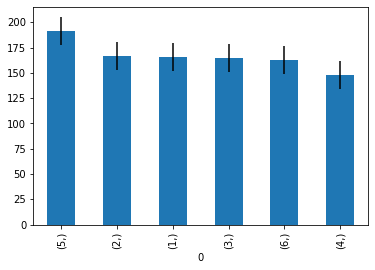

In [11]:
plot(list_1, deviation_1)

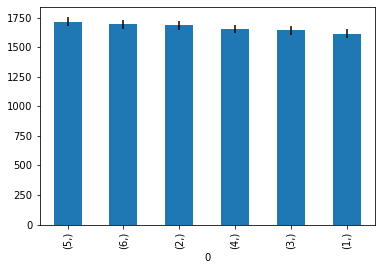

In [12]:
plot(list_10, deviation_10)

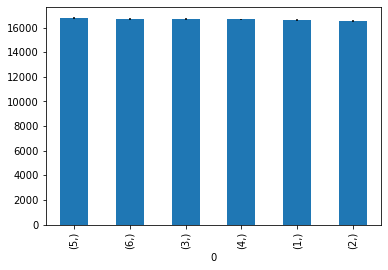

In [13]:
plot(list_100, deviation_100)

In [14]:
def make_biased_die(times):
    sides = list(range(1,7))
    prb = [[(100-(100/6+10))/5] * 5, [100/6+10]]
    flat_prb = []
    for sublist in prb:
        for item in sublist:
            flat_prb.append(item)
    lst = []
    for _ in range(times):
        result = random.choices(sides, flat_prb)
        lst.append(result)
    generated_values = [val for sublist in lst for val in sublist]
    import statistics    
    std = statistics.stdev(pd.DataFrame(generated_values).value_counts())
    return generated_values, std

In [15]:
list_1, deviation_1 = make_biased_die(1000)
list_10, deviation_10 = make_biased_die(10000)
list_100, deviation_100 = make_biased_die(100000)

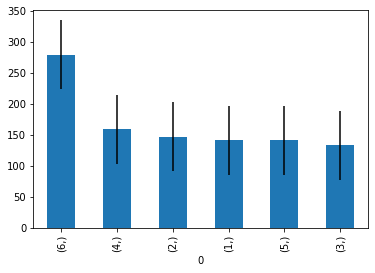

In [16]:
plot(list_1, deviation_1)

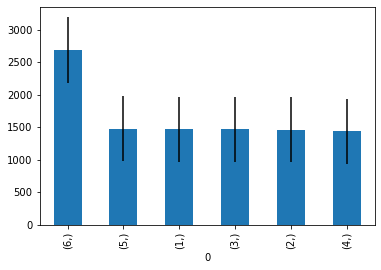

In [17]:
plot(list_10, deviation_10)

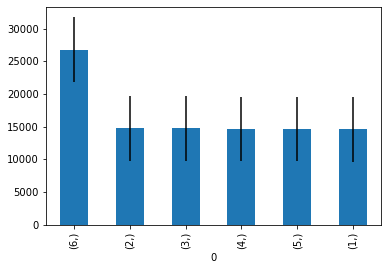

In [18]:
plot(list_100, deviation_100)

## 2. Random Network Model

The random network model, as formulated by Gilbert, has two parameters: the number of nodes $N$, and the link probability $p$. As in the book text, the algorithm for creating this network is as follows:

1. Select a pair of nodes, say i and j.
2. Generate a random number r between 0 and 1. If r < p, then add a link between i and j.
3. Repeat (1) and (2) for all pairs of nodes.

We'll need a couple of tools from Python for this task:

### Generating combinations

We've previously looped over all nodes in a graph, as well as all graph edges, but this algorithm requires us to loop over all *pairs* of nodes, *i.e.* all possible edges. The `itertools` module in Python's standard library gives us the [combinations()](https://docs.python.org/3.7/library/itertools.html#itertools.combinations) function, an elegant way to loop over pairs of elements in a sequence:

In [19]:
elements = [0, 1, 2, 3, 4]
list(itertools.combinations(elements, 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

The second argument to `itertools.combinations()` is the length of the sequences we want in the output. Since we want pairs, we'll specify 2. Note the nice properties of the output:

1. No repeat elements -- we don't want to consider self-loops like `('a', 'a')`.
2. Pairs are in sorted order -- `('a', 'b')` and `('b', 'a')` are the same edge in an undirected graph.

We can thus use this to loop over all pairs of nodes in a graph:

In [20]:
G = nx.Graph()
G.add_nodes_from(elements)

list(itertools.combinations(G.nodes, 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

### Gilbert random graph model

With these tools in our toolbelt, we can code the algorithm for the Gilbert random graph model.

In [21]:
def gnp_random_graph(N, p):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    for i, j in itertools.combinations(G.nodes, 2):
        r = random.random()
        if r < p:
            G.add_edge(i, j)
        # Do nothing if r >= p
        
    return G

We can use this function to generate a graph. Since this is a random graph, each execution of the following code will generate a different graph. 

Graph has 22 edges.


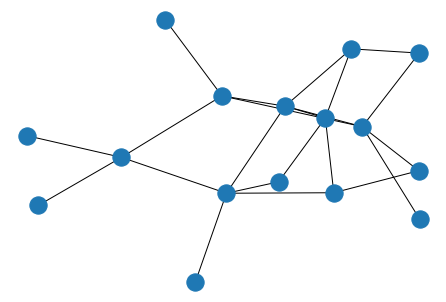

In [24]:
G = gnp_random_graph(16, 0.15)
nx.draw(G)
print('Graph has', G.number_of_edges(), 'edges.')

Run the above cell a few times and note that the number of edges varies slightly among random graphs generated with the same parameters. This is because each pair of nodes has an independent chance of being an edge.

### Erdös-Rényi random graph model

Instead of specifying the link probability $p$, we can also generate a graph of $N$ nodes with exactly $M$ edges by using `random.sample()` to choose M of the possible edges generated with `itertools.combinations()`:

In [25]:
def gnm_random_graph(N, M):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    possible_edges = itertools.combinations(G.nodes, 2)
    edges_to_add = random.sample(list(possible_edges), M)
    G.add_edges_from(edges_to_add)
    
    return G

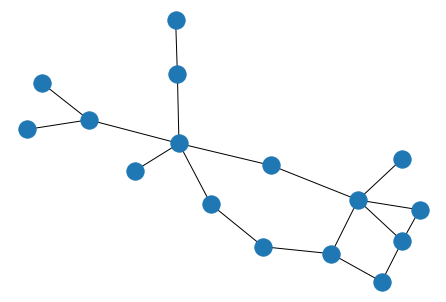

In [32]:
G = gnm_random_graph(16, 18)
nx.draw(G)

### NetworkX functions

NetworkX has a function for the $G_{n,p}$ random graph specifying number of nodes $N$ and link probability $p$:  [gnp_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html).

In addition, NetworkX provides [gnm_random_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html), which generates a $G_{n,m}$ graph, where we specify the number of nodes $N$ and the desired number of edges $M$.

# Exercise 2  (4 pts)

Consider a Gilbert random graph with 500 nodes and iterate over the connection probability p

o   find a meanigful range for p and measure the number of connected components, the size of the largest connected component, 
    the average degree and the average shortest path length (spl)

o   plot all measured quatities over p so that the different regimes become apparent

o   plot the the largest connected component and the the average spl over the average degree


Subcritical


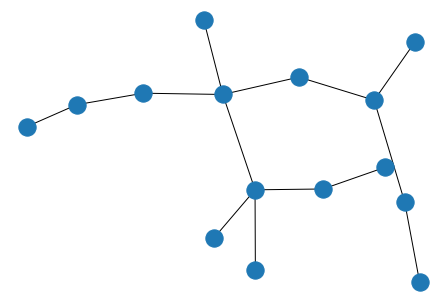

Critical


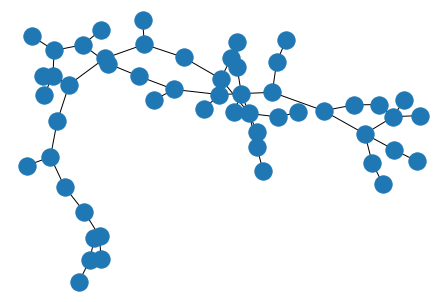

Supercritical


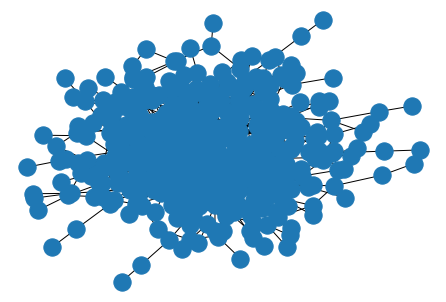

Connected


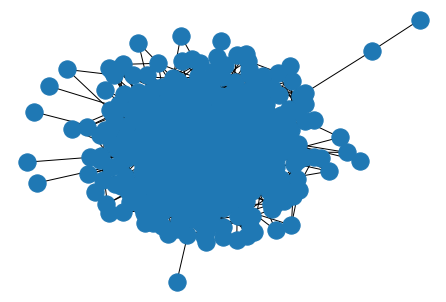

In [221]:
from statistics import mean
k_list = [0.5, 1, 3, np.log(500)]
phases_list = ['Subcritical', 'Critical', 'Supercritical', 'Connected']
p_list = []
for k in k_list:
    p = round(k/(500-1), 3)
    p_list.append(p)
dictionary = dict(zip(phases_list, p_list))
df_meaningful = pd.DataFrame.from_dict(dictionary, orient='index', columns=['p'])
lst = []
size_lst = []
ave_deg = []
spl = []
for key, value in dictionary.items():
    G = gnp_random_graph(500, value)
    lst.append(nx.number_connected_components(G))
    size_lst.append([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)][0])
    degrees = dict(G.degree())
    sum_of_edges = sum(degrees.values())
    ave_deg.append(sum_of_edges/500)
    spl_lst = []
    for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
        spl_lst.append(nx.average_shortest_path_length(C))
    spl.append(mean(spl_lst))
    
    # plot the largest connected component
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    print(key)
    plt.figure()
    nx.draw(G0)
    plt.show()

df_meaningful['number_connected_components'] = lst
df_meaningful['size_of_largest_component'] = size_lst
df_meaningful['average_degree'] = ave_deg
df_meaningful['average spl of components'] = spl

In [215]:
df_meaningful

,p,number_connected_components,size_of_largest_component,average_degree,average spl of components
Subcritical,0.001,372,12,0.512,0.250244
Critical,0.002,251,39,0.996,0.428034
Supercritical,0.006,29,472,3.016,0.189040
Connected,0.012,3,498,6.320,1.187653


plot all measured quatities over p so that the different regimes become apparent

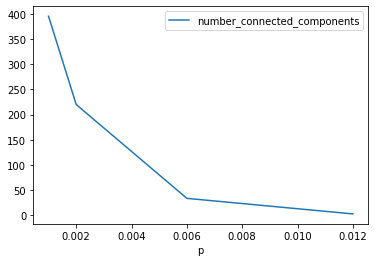

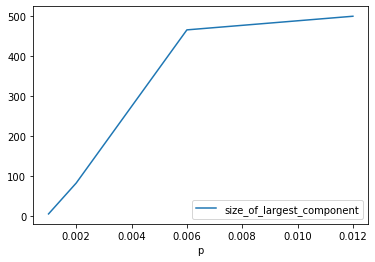

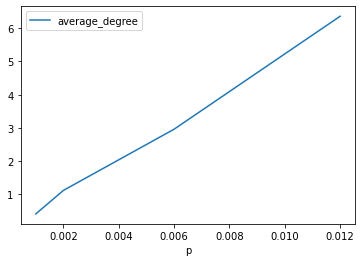

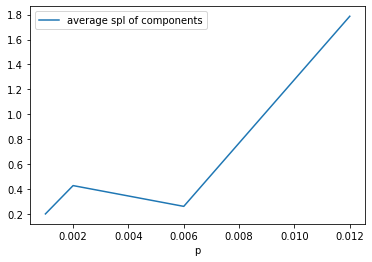

In [203]:
for column in df_meaningful.iloc[:,[1,2,3,4]]:
    df_meaningful.plot(x="p", y=column)

average spl over the average degree

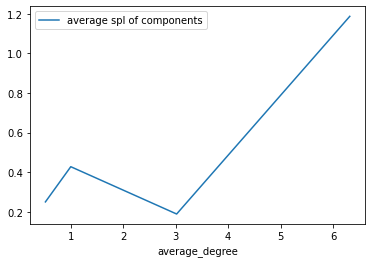

In [216]:
for column in df_meaningful.iloc[:,[4]]:
    df_meaningful.plot(x="average_degree", y=column)

# Exercise 3 (2 pts)

Compare the random graph with a regular lattice 

o generate a 2d lattice as a network (`nx.grid_2d_graph(n,m)`) and make a layout using `nx.spring_layout(G,iterations = 100)` 

o draw the network, try using more iteration steps

o iterate over a meaningful range of network sizes and measure the average spl for both, the random graph and the lattice graph and  
plot both in one figure
